<img src="images/Explicabilidade em Modelos de Machine Learning com SHAP.jpg" width="800px">

## Sumário: <a class="anchor" id="inicio"></a>
* [O que é interpretabilidade?](#1)
* [Proposta do SHAP](#2)
  * [Valores de Shapley](#2-1)
  * [Let us play a game](#2-2)
* [Explicando...?](#3)
* [Como atribuir um valor justo? Enters Lloyd Shapley](#4)
  * [Propriedades de uma atribuição justa](#4-1)
* [Exemplo: explicanco a probabilidade de clique ](#5)
  * [Os dados](#5-1)
  * [O modelo de predição](#5-2)
  * [Feature importances](#5-3)
* [Here comes the SHAP](#6)
  * [Summary plot](#6-1)
  * [Force plot e mais](#6-2)

## O que é interpretabilidade? <a class="anchor" id="1"></a>

When it comes to predictive modeling, you have to make a trade-off: Do you just want to know what is predicted? For example, the probability that a customer will churn or how effective some drug will be for a patient. Or do you want to know why the prediction was made and possibly pay for the interpretability with a drop in predictive performance?

<img src="images/ml-model.png" width="800px">

Quando um modelo de machine learning tem uma boa performance devemos simplesmente ignorar o motivo que o leva a tomar certas decisões?

Não. Um conjunto pequeno de métricas não consegue capturar toda a complexidade de um modelo que trata de situações reais.

Digamos que o seu modelo seja capaz de prever se um produto irá vender. Você agora pode responder se um produto será ou não vendido (**Qual é a predição?**). Isso possivelmente não é suficiente para a empresa. É importante saber o que o leva a vender (**Por que ele tem essa predição?**).

## Proposta do SHAP <a class="anchor" id="2"></a>

O SHAP (SHapley Additive explanations) é um método que se propõe a explicar a saída de **qualquer** modelo de machine learning. Os autores afirmam que ele foi criado unindo outros métodos e representa "the only possible consistent and locally accurate additive feature attribution method based on expectations".

Referências:  
  - https://shap.readthedocs.io/en/latest/index.html
  - http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf
  - https://arxiv.org/pdf/1802.03888.pdf
  - https://en.wikipedia.org/wiki/Shapley_value
  - https://towardsdatascience.com/interpreting-your-deep-learning-model-by-shap-e69be2b47893
  - https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83  

### Valores de Shapley <a class="anchor" id="2-1"></a>

Sendo um dataset $X$ com um determinado número de features $x_{i}$ e com output target $y$, consideramos que cada um dos features é um jogador em um jogo colaborativo e o target é a recompensa final de todos os jogadores somados. O Valor de Shapley de cada jogador indica quanto este recebe da recompensa final.

Assim, vemos o jogo como a tarefa de prever o valor de saída de uma observação (amostra, produtos, item, etc) e a recompensa é o valor da previsão menos a previsão média para o restante do dataset. O desempenho dos jogadores são os valores das features da observação, estes colaboraram para obter a recompensa (prever um certo valor).

A definição mais precisa do Valor de Shapley é: a média marginal da contribuição do valor de uma feature ao longo de todas as possíveis coalisões.

### Let us play a game <a class="anchor" id="2-2"></a>

Um jogo com 4 jogadores; dados de cada partida com o ganho total.
Quanto do ganho total deve ser dado a cada jogador? Qual é o valor justo para a contribuição de cada um???

In [1]:
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import shap

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w

shap    0.38.1
xgboost 0.90
numpy   1.18.5
seaborn 0.9.0
pandas  0.25.2
last updated: Tue Jan 19 2021 

CPython 3.6.9
IPython 7.8.0
watermark 2.0.2


In [4]:
def make_data():
    X,y = make_regression(
        n_samples=2000,
        n_features=4,
        n_informative=3,
        n_targets=1,
        bias=6,
        noise=3,
        random_state=42
                        )
    X += 10
    X = np.concatenate((X,np.random.randint(5,18,size=(X.shape[0],1))),axis=1)
    X = np.round(X,0)

    y = 1.9*abs(X[:,0]) + 0.5*X[:,1]*(0.5*(X[:,2])-5) + 1.5*np.exp(-0.001*X[:,3]/(X[:,0]+10))
    y = np.round(y,0)

    df = pd.DataFrame(data=X,columns = ['Jogador_A','Jogador_B','Jogador_C','Jogador_D','Jogador_E'])
    df['Ganho'] = y
    return df

In [5]:
df = make_data()
df.head()

,Jogador_A,Jogador_B,Jogador_C,Jogador_D,Jogador_E,Ganho
0,10.0,11.0,9.0,10.0,8.0,18.0
1,11.0,11.0,11.0,12.0,9.0,25.0
2,12.0,12.0,12.0,11.0,17.0,30.0
3,7.0,11.0,9.0,8.0,15.0,12.0
4,11.0,10.0,10.0,9.0,11.0,22.0


In [6]:
def plot_y_vs_X():
    plt.figure(figsize=(20,6))
    plt.subplot(151)
    plt.plot(df['Jogador_A'],df['Ganho'],'o')
    plt.ylabel("Ganho")
    plt.xlabel("Jogador_A")
    plt.grid(True)
    plt.subplot(152)
    plt.plot(df['Jogador_B'],df['Ganho'],'o')
    plt.ylabel("Ganho")
    plt.xlabel("Jogador_B")
    plt.grid(True)
    plt.subplot(153)
    plt.plot(df['Jogador_C'],df['Ganho'],'o')
    plt.ylabel("Ganho")
    plt.xlabel("Jogador_C")
    plt.grid(True)
    plt.subplot(154)
    plt.plot(df['Jogador_D'],df['Ganho'],'o')
    plt.ylabel("Ganho")
    plt.xlabel("Jogador_D")
    plt.grid(True)
    plt.subplot(155)
    plt.plot(df['Jogador_E'],df['Ganho'],'o')
    plt.ylabel("Ganho")
    plt.xlabel("Jogador_E")
    plt.grid(True)
    plt.show()

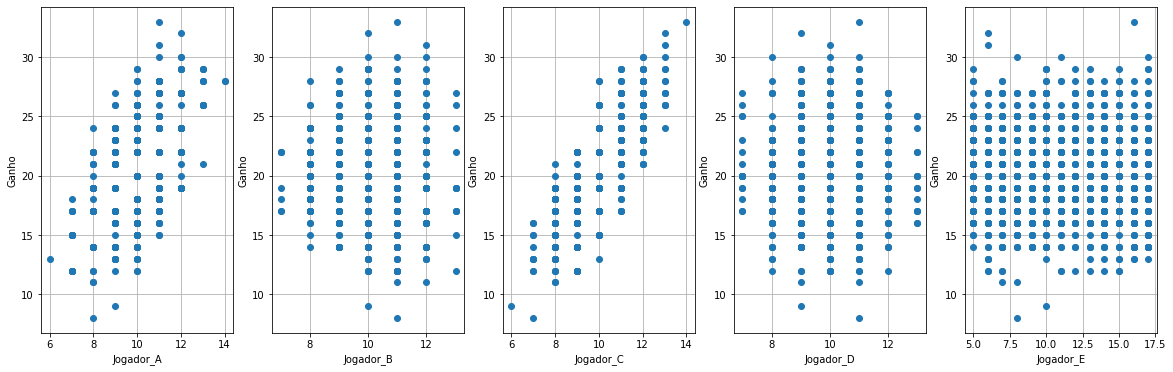

In [7]:
plot_y_vs_X()

Explicar a probabilidade de clique
qualidade de imagem aumenta a prob
numero de imagens nao interfere


In [8]:
X_df = df.drop(["Ganho"],axis=1)
y = df["Ganho"].values

## Explicando...? <a class="anchor" id="3"></a>

Treinamos o xgboost e analisamos as `features importances`

Pergunta: é possível ter uma explicação global e uma local?

In [9]:
model_xgb = XGBRegressor(n_estimators=1000, max_depth=10).fit(X_df, y)
model_lgbm = LGBMRegressor(learning_rate=0.5,num_leaves=500,n_estimators=1000,).fit(X_df,y)

[15:18:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
y_pred_xgb = model_xgb.predict(X_df)
y_pred_lgbm = model_lgbm.predict(X_df)

In [11]:
mae = mean_absolute_error(y,y_pred_xgb)
mse = mean_squared_error(y,y_pred_xgb)
print(f"{model_xgb.__class__}")
print('Erro médio absoluto: {:.8f}\nErro quadrático médio: {:.8f}'.format(mae,mse))

<class 'xgboost.sklearn.XGBRegressor'>
Erro médio absoluto: 0.00058417
Erro quadrático médio: 0.00000162


In [12]:
mae = mean_absolute_error(y,y_pred_lgbm)
mse = mean_squared_error(y,y_pred_lgbm)
print(f"{model_lgbm.__class__}")
print('Erro médio absoluto: {:.8f}\nErro quadrático médio: {:.8f}'.format(mae,mse))

<class 'lightgbm.sklearn.LGBMRegressor'>
Erro médio absoluto: 0.02349552
Erro quadrático médio: 0.01908744


Verificação da linearidade entre a previsão e o valor real:

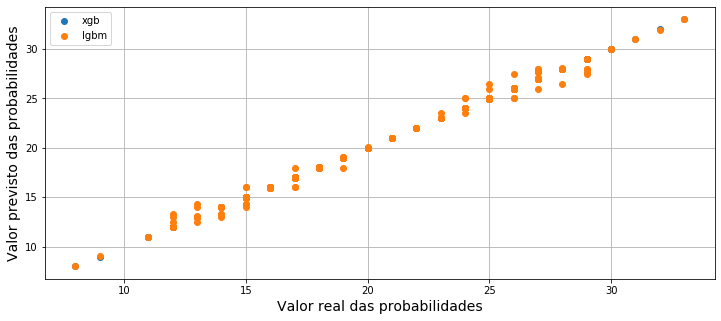

In [13]:
plt.figure(figsize=(12,5))
plt.plot(y,y_pred_xgb,'o',label="xgb")
plt.plot(y,y_pred_lgbm,'o',label="lgbm")
plt.xlabel('Valor real das probabilidades',fontsize=14)
plt.ylabel('Valor previsto das probabilidades',fontsize=14)
plt.legend(loc=0)
plt.grid(True)
plt.show()

A biblioteca usado no treino pode retornar valores chamados `feature importance`. Em modelos baseados em árvores de decisão o `features importances` é a medida mais comum utilizada para explicar a influência dos features no `output` do modelo. Há três opções de métrica para calcular o `feature importances`:
  - Weight: o número de vezes que uma feature é usada para dividir os dados através de todas as árvores;
  - Cover: o número de vezes que uma feature é usada para dividir os dados através de todas as árvores utilizando como peso o número de datapoints em cada um dos splits;
  - Gain: o training loss reduction médio ganho quando um feature é usado no split.
Vamos verificar as importâncias com estas três métricas.

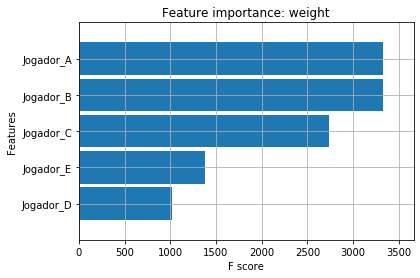

In [14]:
xgboost.plot_importance(model_xgb, importance_type='weight',height=0.9,show_values=False)
plt.title("Feature importance: weight")
plt.show()

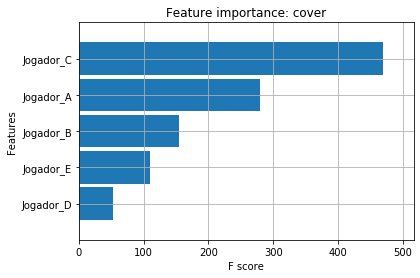

In [15]:
xgboost.plot_importance(model_xgb, importance_type='cover',height=0.9,show_values=False)
plt.title("Feature importance: cover")
plt.show()

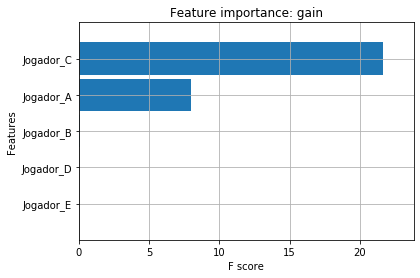

In [16]:
xgboost.plot_importance(model_xgb, importance_type='gain',height=0.9,show_values=False)
plt.title("Feature importance: gain")
plt.show()

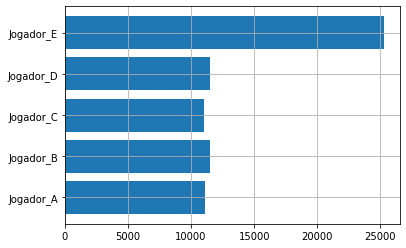

In [17]:
plt.barh(width=model_lgbm.feature_importances_,y=[1,2,3,4,5])
plt.yticks(ticks=[1,2,3,4,5],labels=X_df.columns)
plt.grid(True)
plt.show()

## Como atribuir um valor justo? Enters Lloyd Shapley <a class="anchor" id="4"></a>

To each cooperative game it assigns a unique distribution (among the players) of a total surplus generated by the coalition of all players.

Shapley, Lloyd S. "A value for n-person games." Contributions to the Theory of Games 2.28 (1953): 307-317.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Lloyd_Shapley_2_2012.jpg/1024px-Lloyd_Shapley_2_2012.jpg" width="400px">


### Propriedades de uma atribuição justa <a class="anchor" id="4-1"></a>

1. **Eficiência**: a soma das contibuições de cada featura é a diferença entre a predição da observação e a predição média
$$\sum_{j=1}^{N} \phi_{j} = \hat{f}(x) - \mathbb{E}\left[\hat{f}(X) \right]$$
2. **Simetria**: a contribuição de duas features deve ser igual se ambas contribuem igualmente em todas as possiveis coalisões.
3. **Dummy**: uma feature que não muda o valor predito, independente da coalisão em que está, deve ter valor de Shapley nulo.
4. **Aditividade**: para vários estimadores, o valor de Shapley de uma feature é a média do valor de Shapley entre todos os estimadores.

As importâncias na ordem para cada uma métricas é:

| XGBoost: weight | XGBoost: cover | XGBoost: gain | LGBM |
| --- | --- | --- | --- |
| Jogador_B | Jogador_A | Jogador_A | Jogador_C |
| Jogador_A | Jogador_C | Jogador_C | Jogador_B |
| Jogador_C | Jogador_B | Jogador_B | Jogador_A |
| Jogador_D | Jogador_D | Jogador_D | Jogador_D |

Como podemos ver é possível chegar a conclusões diferentes dependendo da métrica usada para importância. Para determinar a qualidade de atribuição de uma feature duas propriedades devem ser obedecidas independente da métrica usada:

- Consistência: quando muda-se um modelo tal que este depende muito de um feature, a importância atribuída ao feature não pode diminuir;
- Acurácia: A soma de todas as importâncias não deve ultrapassar a importância total do modelo. Ex: Se é usado o $R^{2}$ para medir a importância, a soma de todas as importâncias não deve ultrapassar este valor.

Se a consistência falha não podemos comparar importâncias atribuídas entre modelos diferentes. Se a acurácia falha não sabemos como as atribuições de cada feature se combinam para representar o output do modelo.

Utilizando estas propriedades o método usando os Shapley Values tem se mostrado melhor que outros métodos como Saabas, Gini importance, Split count e Permutation.

Seguimos finalmente para a aplicação do SHAP.

## Exemplo: explicanco a probabilidade de clique <a class="anchor" id="5"></a>

Supomos que nos foi dada a tarefa de entender os motivos de alguns produtos do Elo7 serem mais clicados do que outros. Entendendo estes motivos podemos tomar atitudes junto aos vendedores que permitam aumentar a probablidade de um produto ser clicado e caso positivo pode aumentar a probabilidade de compra.

Para tal tarefa surgiu a ideia de utilizar o SHAP como ferramenta, e como ele explica um modelo de Machine Learning, primeiro precisamos criar o modelo. A utilização do SHAP segue o seguinte pipeline:

<center><p><img src="images/shap_diagram.png"
     alt="SHAP pipeline"
     style="float: left; margin-right: 10px;" /><p/><center/>

O primeiro passo é determinar que features são importantes, ou seja, as características dos produtos poderiam inflienciar na probabilidade de clique. Com os dados em mãos criamos o modelo e fazemos a previsões normalmente. A partir disso fornecemos ao SHAP tanto o modelo quanto os dados e este nos fornece as explicações: como cada features inflencia no resultado da previsão e ainda se há interação entre features.

### Os dados <a class="anchor" id="5-1"></a>

Seguimos então em busca dos dados. Após algum estudo determinamos que os features usados no modelo são:  
   - `Image_quality`: os produtos tiveram suas imagens principais analisadas e cada uma recebeu um nota entre $0$ e $6$ aproximadamente;
   - `Number_of_images`: este é o número de imagens diferentes cadastradas para o produto;
   - `Product_price`: o preço do produto escolhido pelo vendedor;
   - `Seller_latitude`: a latitude de onde fica localizado o vendedor;
   - `Seller_longitude`: a longitude de onde fica localizado o vendedor;
   - `Delivery_price_proportion`: o valor do frete mostrado ao usuário dividido pelo valor do produto;
   - `Surprise_feature`: feature aleatória.

Na construção do dataset foram escolhidos $1000$ produtos diferentes e calculada sua probabilidade de clique, o número de cliques recebido pelo produto dividido pelo número de vezes que este foi visto por um usuário. Além disso só foram utilizados dados de usuários que possuíam seu CEP registrado no site para que pudesse ser calculada a `Delivery_price_proportion`.

Assim, temos nossos dados (matriz de produtos x features) que serão usados para prever a probabilidade de clique (target):

In [18]:
df = pd.read_csv("data/shap_dataset_example.csv")

Seguem algumas amostras:

In [19]:
df.head()

,Image_quality,Number_of_images,Product_price,Seller_latitude,Seller_longitude,Delivery_price_proportion,Click_probability,Surprise_feature
0,2.0,4.0,36.33,-1.5,-4.4,1.00,0.35,10
1,3.0,4.0,48.82,-0.4,-2.2,0.99,0.46,5
2,4.0,5.0,21.75,0.0,3.1,0.08,0.45,9
3,0.0,4.0,26.86,-0.4,-11.3,1.00,0.07,16
4,2.0,5.0,46.20,-0.6,-7.0,1.00,0.37,9


Selecionamos os dados $X$ que serão usados para prever $y$.

In [20]:
X = df.drop('Click_probability',axis=1)
y = df['Click_probability'].values

Verificamos se há linearidade entre as features e o target

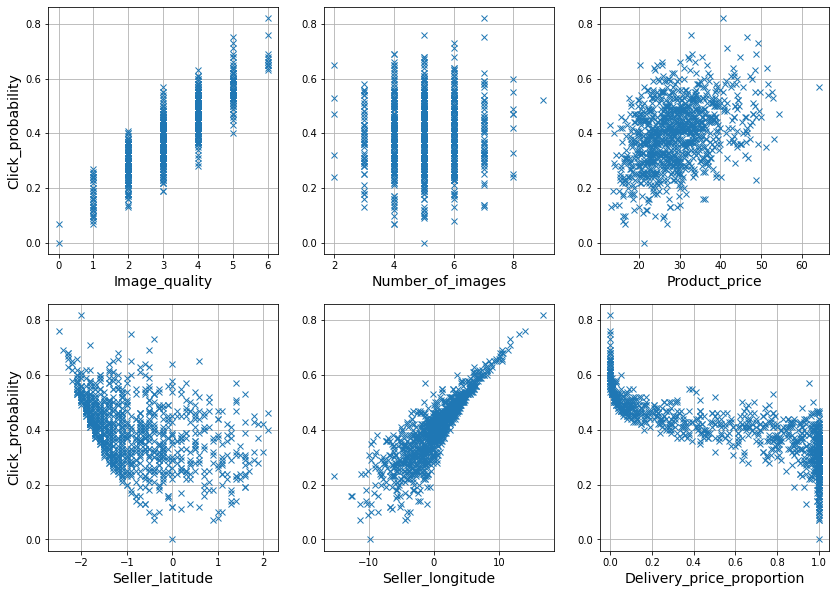

In [21]:
plt.figure(figsize=(14,10))
plt.subplot(231)
plt.plot(df['Image_quality'],y,'x')
plt.ylabel('Click_probability',fontsize=14)
plt.xlabel('Image_quality',fontsize=14)
plt.grid(True)
plt.subplot(232)
plt.plot(df['Number_of_images'],y,'x')
plt.xlabel('Number_of_images',fontsize=14)
plt.grid(True)
plt.subplot(233)
plt.plot(df['Product_price'],y,'x')
plt.xlabel('Product_price',fontsize=14)
plt.grid(True)
plt.subplot(234)
plt.ylabel('Click_probability',fontsize=14)
plt.plot(df['Seller_latitude'],y,'x')
plt.xlabel('Seller_latitude',fontsize=14)
plt.grid(True)
plt.subplot(235)
plt.plot(df['Seller_longitude'],y,'x')
plt.xlabel('Seller_longitude',fontsize=14)
plt.grid(True)
plt.subplot(236)
plt.plot(df['Delivery_price_proportion'],y,'x')
plt.xlabel('Delivery_price_proportion',fontsize=14)
plt.grid(True)
plt.show()

Vemos inicialmente que há uma dependência linear clara entre a qualidade da imagem e a probabilidade de clique, o número de imagens e o preço do produto são difíceis de ser interpretada. Entretanto, é possível ver que a localidade do vendedor interfere na probabilidade de clique. Isso pode ter várias interpretações: os vendedores podem morar em grandes centros permitindo um frete mais barato ou mesmo grátis; podem morar em lugares onde a concorrência é maior o que fez com que estes fizessem cursos de fotografia para melhor apresentar seus produtos; pode ainda ser que estes produtos tenham sido ranqueados e mostrados aos usuários baseados na proximidade física e portanto seriam mais atraentes aos usuários; diversas outras explicações podem ser levantadas. Na proporção de frete vemos que quanto maior é esta menor a probabilidade de clique, mas não há uma relação linear e ela tende a ficar mais dispersa para valores de proporção de frete próximas de $1$.

Com a latitude e longitude pode ainda verificar a localização dos produtos mais clicados:

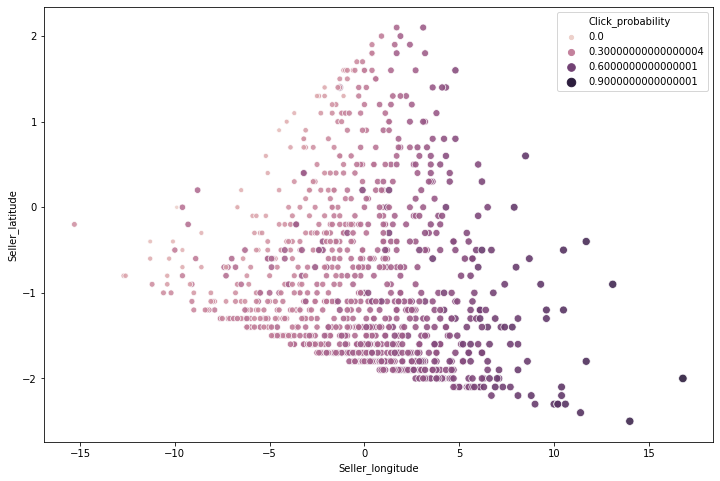

In [22]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Seller_longitude',y='Seller_latitude',data=df,hue='Click_probability',size='Click_probability',alpha=0.9)
plt.show()

### O modelo de predição <a class="anchor" id="5-2"></a>

Seguimos assim para o treinamento do modelo utilizando algum algoritmo apropriado para o caso.  
Obs: Como o foco não é o modelo de machine learning em si pularemos passos de pré-processamento e consideraremos que a etapa de feature engineering já foi concluída.

Treino do modelo:

In [23]:
model = xgboost.XGBRegressor(n_estimators=1000, max_depth=50).fit(X, y)

[15:19:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Cálculo das previsões:

In [24]:
y_pred = model.predict(X)

Verificação dos erros de previsão:

In [25]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
print('Erro médio absoluto: {:.8f}\nErro quadrático médio: {:.8f}'.format(mae,mse))

Erro médio absoluto: 0.00047077
Erro quadrático médio: 0.00000038


Verificação da linearidade entre a previsão e o valor real:

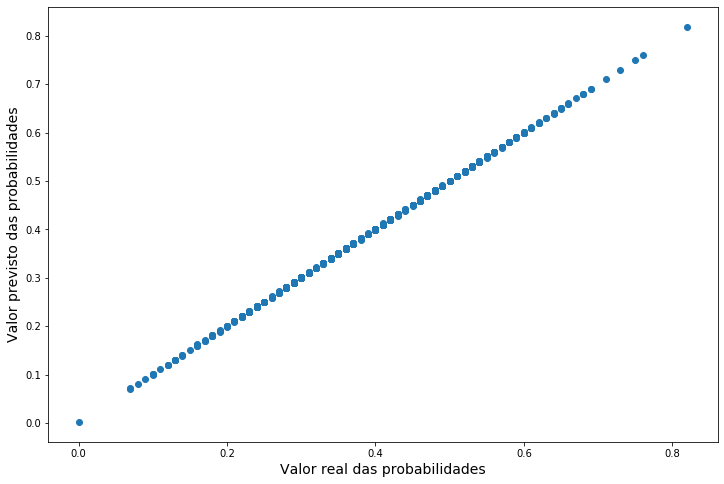

In [26]:
plt.figure(figsize=(12,8))
plt.plot(y,y_pred,'o')
plt.xlabel('Valor real das probabilidades',fontsize=14)
plt.ylabel('Valor previsto das probabilidades',fontsize=14)
plt.show()

Podemos fazer uma previsão de teste para um produto novo da base:

In [27]:
x_sample = np.array([[3.0,3,25.99,-0.3,1.1,0.5,18,1]])

In [28]:
y_sample = model.predict(x_sample,validate_features=False)

In [29]:
print("Probabilidade de clique para o novo produto cadastrado: {:.1%}".format(y_sample[0]))

Probabilidade de clique para o novo produto cadastrado: 39.3%


Contentes com o modelo seguimos para a aplicação do SHAP.

### Feature importances <a class="anchor" id="5-3"></a>

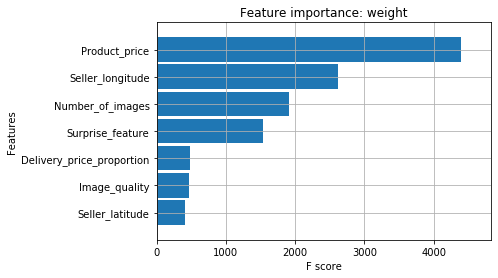

In [30]:
xgboost.plot_importance(model, importance_type='weight',height=0.9,show_values=False)
plt.title("Feature importance: weight")
plt.show()

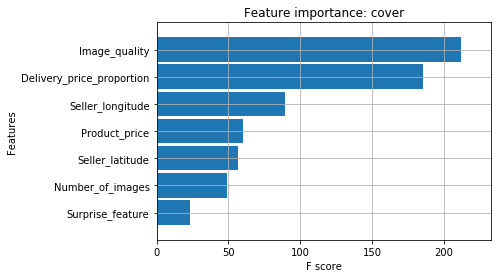

In [31]:
xgboost.plot_importance(model, importance_type='cover',height=0.9,show_values=False)
plt.title("Feature importance: cover")
plt.show()

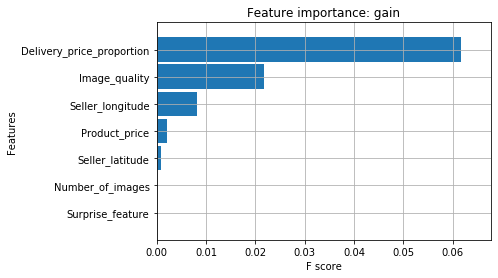

In [32]:
xgboost.plot_importance(model, importance_type='gain',height=0.9,show_values=False)
plt.title("Feature importance: gain")
plt.show()

As importâncias na ordem para cada uma métricas é:

| weight | cover | gain |
| --- | --- | --- |
| Product_price             | Image_quality             | Delivery_price_proportion|
| Seller_longitude          | Delivery_price_proportion | Image_quality|
| Number_of_images          | Seller_longitude          | Seller_longitude|
| Surprise_feature          | Product_price             | Product_price  |
| Delivery_price_proportion | Seller_latitude           | Seller_latitude|
| Image_quality             | Number_of_images          | Number_of_images|
| Seller_latitude           | Surprise_feature          | Surprise_feature|

## Here comes the SHAP <a class="anchor" id="6"></a>

In [33]:
import shap
shap.__version__

'0.38.1'

In [34]:
shap.initjs()

Como o modelo é uma árvore usamos o `TreeExplainer` passando o modelo treinado para o mesmo.

In [35]:
X_sample = X.sample(100)
explainer = shap.Explainer(model, X_sample)
explainer_tree = shap.TreeExplainer(model)
shap_values = explainer(X)

shap_values_tree = explainer_tree(X)

Utilizando o explicador calculamos o Shapley value de cada feature para cada amostra (produto).

In [36]:
# shap_values = explainer.shap_values(X)

Podemos ainda calcular um Shapley value para a interação de features.

In [37]:
%%time
shap_interaction_values = explainer_tree.shap_interaction_values(X)

CPU times: user 29.1 s, sys: 0 ns, total: 29.1 s
Wall time: 29.1 s


O gráfico a seguir mostra o módulo do valor médio do Shapley value de cada feature. Inicialmente vemos que a qualidade da imagem tem a maior contribuição como esperado, pois é como o produto é apresentado ao usuário e a imagem é característica mais interpretável. Em segundo lugar está a proporção de frete seguido do preço do produto. Estes dois são fatores de decisão de compra e são mostradas ao usuário junto a imagem em menor destaque. Os features Seller_longitude e Seller_latitude têm uma contribuição menor, possívelmente pq devem estar ligado ao valor de frete. Já o número de imagens do produtos possui também uma atribuição pequena e isso já deveria ser esperado, pois no Elo7 o usuário apenas consegue ver outras imagens do produto após o clique e nem deveria ter sido escolhida como feature, o que não é o caso quando a feature importance é calculada usando o weight como métrica.

### Summary plot <a class="anchor" id="6-1"></a>

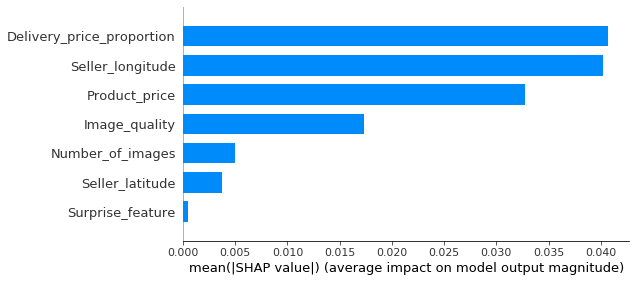

In [38]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [39]:
def summary_plot_non_absolute(shap_values,dataframe,confidence_interval=False):
    mean_shap = np.mean(shap_values,axis=0)
    if confidence_interval:
        err_shap= np.var(shap_values,axis=0)*1.96/np.sqrt(X.shape[0])
        s = sorted(zip(mean_shap,err_shap),reverse=True)
        mean_shap,err_shap = map(np.array,zip(*s))
    else: 
        mean_shap = sorted(mean_shap,reverse=True)
        err_shap = None
    
    plt.figure(figsize=(9,6))
    sns.set(style="whitegrid")
    ax = sns.barplot(
        y = dataframe.columns, 
        x = mean_shap,
       
        errcolor='k',
        errwidth=10,
        color='#008ce0')
    plt.errorbar(y = dataframe.columns,x = mean_shap,xerr=err_shap, fmt='.')
    plt.xlabel("Mean Shap value: average impact on model output magnitude",fontsize=15)
    plt.show()

O gráfico seguinte mostra o mesmo resultado anterior, porém leva em conta o sinal do Shapley value. É interessante usar a variável `confidence_interval` como `True` caso se tenha dúvida quanto ao valor médio dos Shapley values. Para tal foi utilizado um intervalo de confiança de $95\%$.

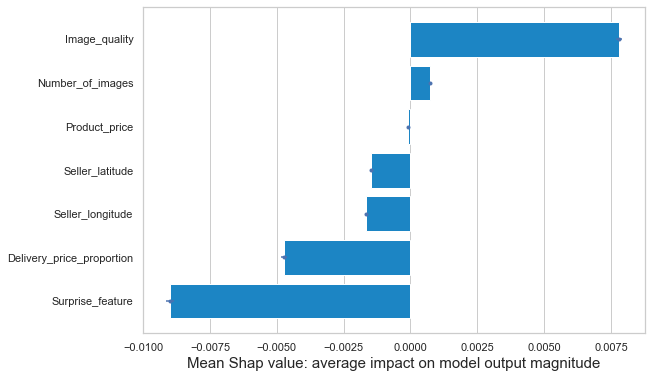

In [40]:
summary_plot_non_absolute(shap_values.values,X,confidence_interval=True)

Como devemos interpretar estes resultados?

O Shapley value de um feature é sua atribuição, ou seja, quanto em média ele colabora para que o resultado de uma previsão se afaste do valor médio das previsões.

Vamos entender isso analisando o primeiro produto do dataset.

In [41]:
sample_id = 0
df_sample = pd.DataFrame(
    {
        "Feature_values":X.iloc[sample_id].values,
        "Shapley_values":shap_values.values[0]
    },index = X.columns)

df_sample

,Feature_values,Shapley_values
Image_quality,2.00,-0.022895
Number_of_images,4.00,-0.005265
Product_price,36.33,0.055994
Seller_latitude,-1.50,0.006499
Seller_longitude,-4.40,-0.045873
Delivery_price_proportion,1.00,-0.044503
Surprise_feature,10.00,-0.000010


In [42]:
print("Valor real do sample 0: {:.4f}".format(y[sample_id]))
print("Valor previsto do sample 0: {:.4f}".format(y_pred[sample_id]))
print("Valor médio das previsões: {:.4f}".format(np.mean(y_pred)))
print("A diferença entre a previsão e o valor médio: {:.4f}".format(y_pred[sample_id]-np.mean(y_pred)))
print("A soma dos Shapley values da amostra: {:.4f}".format(np.sum(shap_values.values[sample_id])))

Valor real do sample 0: 0.3500
Valor previsto do sample 0: 0.3496
Valor médio das previsões: 0.3972
A diferença entre a previsão e o valor médio: -0.0476
A soma dos Shapley values da amostra: -0.0561


A amostra de exemplo teve previsão $0.0476$ abaixo da média. Para essa amostra as features `Product_price` e `Seller_latitude` tiveram uma contribuição positiva, enquanto as demais contribuiram negativamente. O Shapley value de cada uma é a explicação de como cada feature contribuiu para que a probabilidade de clique se afastasse da média.

A estimativa da contribuição se dá da seginte maneira: Consideramos a coalisão entre `Image_quality`, `Product_price` e`Delivery_price_proportion` para um produto escolhendo aleatoriamente o valor dos outros features de outros produtos do dataset. Então prevemos a `Click_probability`, digamos que seja $0.3470$. Agora para estimar a contribuição de `Image_quality` na coalisão fazemos uma nova previsão removendo este valor e substituindo pelo valor de outro produto escolhido aleatoriamente, digamos que resulte em $0.3780$. A contribuição de `Image_quality` é a quantidade $0.3470-0.3780=-0.0310$. Conforme este procedimento é repetido várias vezes a estimativa das contribuições se aproxima do valor real.
Além disso o procedimento ainda é realizado para todas as combinações possíveis de coalisão. Notemos então que o tempo de computação cresce com o número de features.

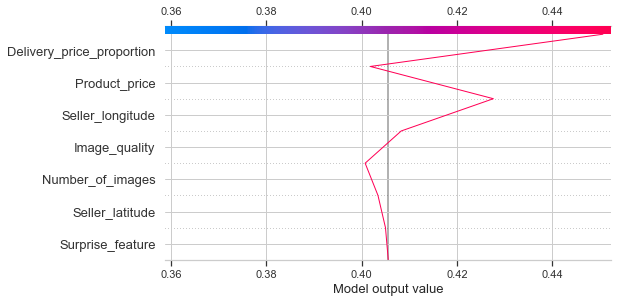

In [43]:
sample_id = 2
shap.decision_plot(explainer.expected_value, shap_values.values[sample_id],feature_names=X.columns.tolist())

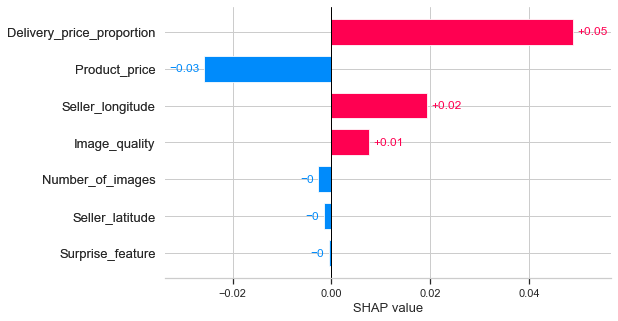

In [44]:
shap.plots.bar(shap_values[sample_id])

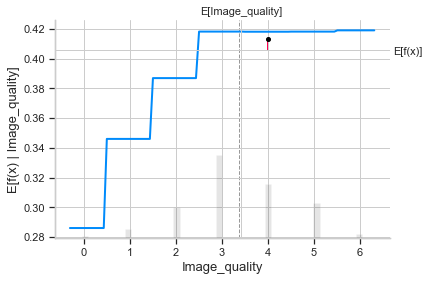

In [45]:
shap.plots.partial_dependence(
    "Image_quality", model.predict, X_sample, ice=False,feature_names=X.columns,
    model_expected_value=True, feature_expected_value=True,shap_values=shap_values[sample_id:sample_id+1,:]
)

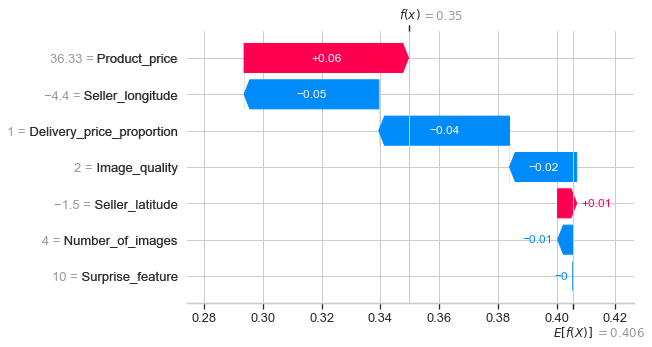

In [46]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_ind = 0
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

### Force plot e mais<a class="anchor" id="6-2"></a>

Uma maneira que a biblioteca SHAP possui de apresentar as contribuições para uma amostra é utilizando o `force_plot`. Em vermelho vemos as as features que contribuiram positivamente e em azul negativamente. Uma contribuição positiva significa "forçar" o valor da previsão para cima da média e contribuição negativa o caso contrário.

In [47]:
sample_id = 0
shap.force_plot(explainer.expected_value, shap_values.values[sample_id,:], X.iloc[sample_id,:])

Devemos lembrar que esta visualização é para uma amostra, outras amostras podem ter recebido, por exemplo, uma contribuição negativa da feature `Product_price`. Para observar as contribuições como um todo podemos usar o `force_plot` para todo o dataset. Na imagem a seguir o eixo y mostra o `force_plot` e no eixo x estão as amostras do dataset, neste caso ordenadas por similaridade.
Vemos que boa parte das 250 primeiras amostras foram impulsionadas para cima pelas features `Image_quality`, `Delivery_price_proportion` e `Product_price`, enquanto que as últimas amostras foram impulsionadas para baixo pelas mesmas features.

In [48]:
shap.force_plot(explainer.expected_value, shap_values.values, X)

Podemos visualizar um resumo dos Shapley values relacionando-os com a intensidade das features a seguir. Cada ponto é uma amostra e os pontos vermelhos indicam que o valor da feature é próxima do máximo encontrado no dataset e azul o valor mínimo.

Podemos ver que os produtos que possuem a feature `Image_quality` alta se concentram em uma região com Shapley value positivo (impulsionando a `Click_probability` para cima) e parece haver um limite de saturação de Shapley value próximo de $0.05$, ou seja, a partir deste ponto a qualidade das imagens de produto precisam aumentar muito para conseguir alguma contribuição extra. É possível que imagens de qualidade mediana sejam suficientes para ter a atenção dos usuários.

Para `Delivery_price_proportion` parece ser o caso contrário. Valores altos, próximos de $1$ tem contribuição negativa e valores próximos de $0$ podem contribuir ainda mais que `Image_quality`.

`Product_price` parece bem distribuído em torno de $0$, mas pode atingir valores maiores que $0.1$ e menores que $-0.1$. A influência do preço é delicada pois um produto pode ser caro justamente por ser muito atraente, indicando uma qualidade alta.

A localização dos vendedores parece não importar em relação a latitude, enquanto que a longitude indica que há regiões previlegiadas.

Como dito anteriormente o `Number_of_images` não parece ter influência significativa na previsão, seus valores se concentram em torno de $0$ com pequena dispersão. A influência desta feature pode ser indireta, é possível que vendedores mais preocupados com a imagem do produto acabem utilizando mais imagens para mostrar detalhes.

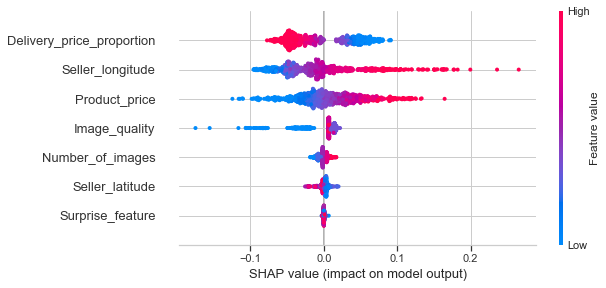

In [49]:
shap.summary_plot(shap_values, X)

Os valores de interação, `shapley_interaction_values`, são importantes pois pode haver correlação direta entre features ou apenas para certas regiões de valores.

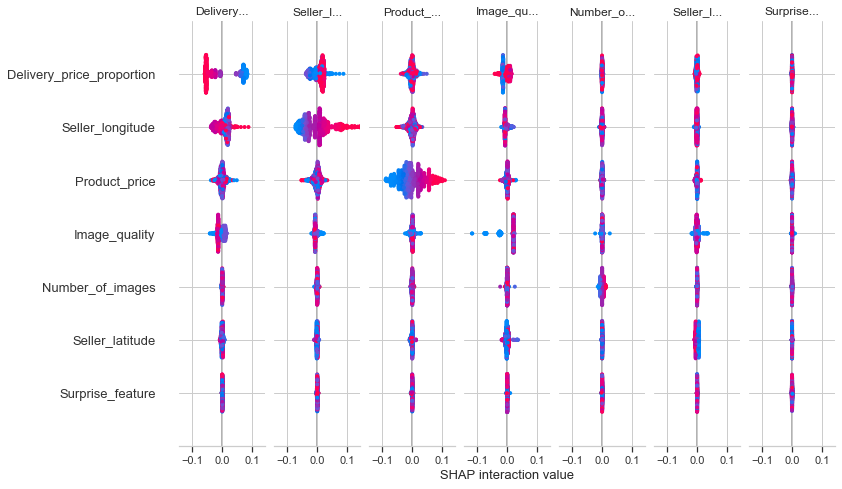

In [50]:
shap.summary_plot(shap_interaction_values, X)

Podemos observar individualmente a dependência de cada feature com o Shapley value e que outro feature intege com este observado, usando o `dependence_plot`. Na imagem a seguir vemos que imagens com score menor que aproximadamente $2.8$ tem contribuição negativa, poderíamos determinar que imagens com score abaixo desse valor são imagens pouco atraentes para o usuário. Além disso vemos que a contribuição cresce linearmente até um score de aproximadamente $3.3$ e não muda muito acima disso. Assim, o score $3.3$ poderia ser considerado um "padrão de qualidade" mínimo para o Elo7. Outra observação é que o `Product_price` se distribui aparentemente de forma homogênea indicando que este não se correlaciona com `Image_quality`, o que pode ser observado no gráfico seguinte.

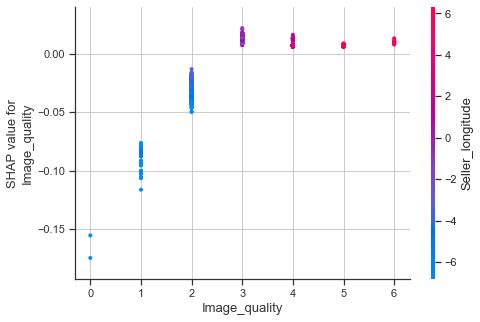

In [51]:
shap.dependence_plot("Image_quality", shap_values.values, X)

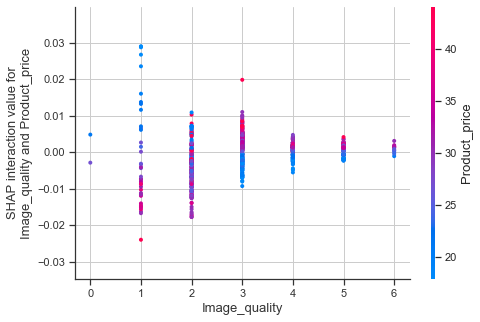

In [52]:
shap.dependence_plot(("Image_quality",'Product_price'), shap_interaction_values, X)

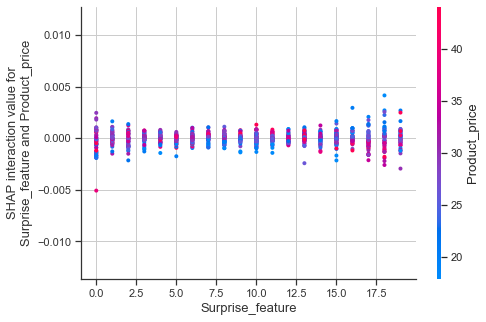

In [53]:
shap.dependence_plot(("Surprise_feature",'Product_price'), shap_interaction_values, X)

Analisando o dependence plot de `Delivery_price_proportion` identificamos algo interessante, os produtos com `Delivery_price_proportion` abaixo de $0.4$ tem contribuição positiva e também são produtos que possuem `Image_quality` alto, acima de $3.3$ aproximadamente.

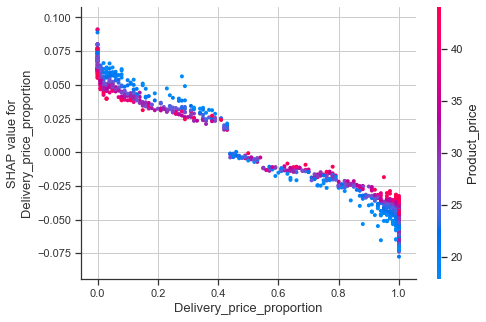

In [54]:
shap.dependence_plot("Delivery_price_proportion", shap_values.values, X)

O próximo gráfico mostra como estas features interagem. A interação é positiva em dois casos: quando a `Image_quality` está entre $2$ e $3.3$ e `Delivery_price_proportion` está aparentemente entre $0.6$ e $0.85$; e se `Image_quality` é maior que $5.3$ e `Delivery_price_proportion` é menor que $0.1$.

Uma interação positiva significa que os features contribuem na mesma direção, impulsionam o resultado da previsão para cima ou para baixo juntos. A interação negativa significa que se um impulsiona o resulta para cima o outro impulsiona para baixo.

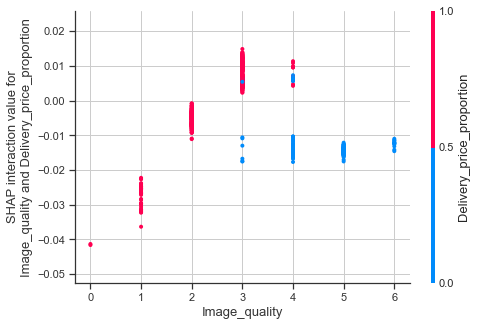

In [55]:
shap.dependence_plot(("Image_quality",'Delivery_price_proportion'), shap_interaction_values, X)

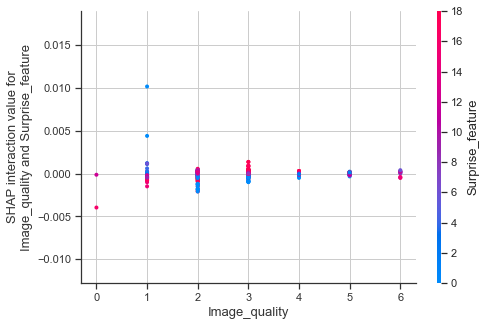

In [56]:
shap.dependence_plot(("Image_quality",'Surprise_feature'), shap_interaction_values, X)

Em caso de dúvida ou para uma melhor análise pode visualizar de outra maneira.

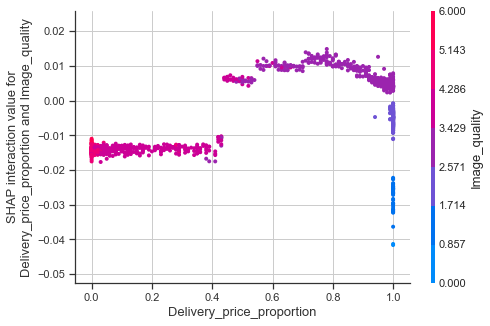

In [57]:
shap.dependence_plot(('Delivery_price_proportion',"Image_quality"), shap_interaction_values, X)

Seguem abaixo alguns outros exemplos usando o dependence plot e a interpretação fica a cargo do leitor.

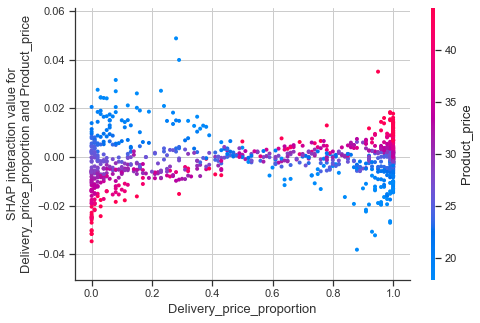

In [58]:
shap.dependence_plot(('Delivery_price_proportion',"Product_price"), shap_interaction_values, X)

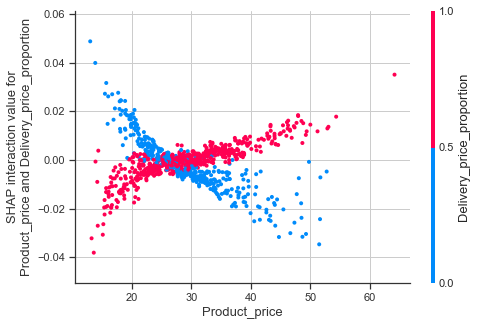

In [59]:
shap.dependence_plot(("Product_price",'Delivery_price_proportion'), shap_interaction_values, X)

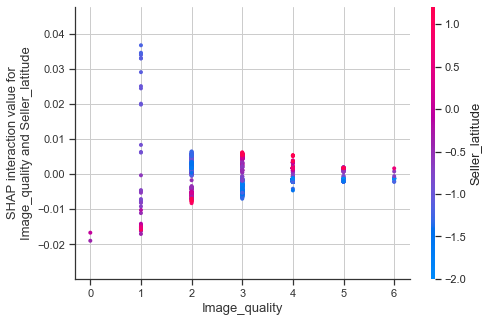

In [60]:
shap.dependence_plot(("Image_quality",'Seller_latitude'), shap_interaction_values, X)

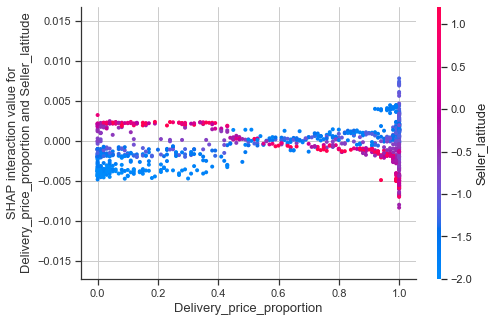

In [61]:
shap.dependence_plot(
    ('Delivery_price_proportion',"Seller_latitude"), shap_interaction_values, X)

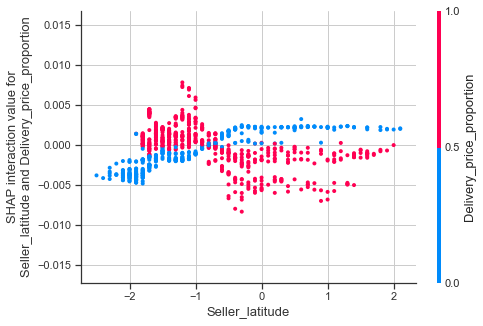

In [62]:
shap.dependence_plot(
    ('Seller_latitude',"Delivery_price_proportion"), shap_interaction_values, X)

Outra visualização do force plot pode ser obtida selecionando no eixo y o efeito da feature. Selecionando `Image_quality effects` vemos que a maior parte do dataset é impulsionada para cima por esta feature.

Se selecionarmos agora no eixo x `Delivery_price_proportion` vemos que em praticamente todos os produtos com esta feature abaixo de 0.95 são impulsionadas positivamente por `Image_quality`.

In [63]:
shap.force_plot(explainer.expected_value, shap_values.values, X)

Analisando `Image_quality effects` e `Seller_longitude` vemos claramente que os vendedores localizados em uma longitude menor que $-0.2$ vendem produtos com imagens ruins. Esta poderia ser uma região na qual os vendedores não tem acesso a um curso de fotografia ou a equipamentos bons.

[**Voltar ao início**](#inicio)